In [1]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeat
import earthplot as eplt
import Myclass as Mc

# %matplotlib inline

In [2]:
lonw, lone, lats, latn = 0, 180, 0, 80
pvalue = 0.05

day = 0
nst1 = 1  # 2
nst2 = 4  # 8

In [3]:
region = 'ESWC'  #change1
dir1 = rf'E:\data\ERA5\REPE\z/'
dir2 = rf'E:\data\ERA5\REPE\u/'
dir3 = rf'E:\data\ERA5\REPE\v/'
dir4 = rf'E:\data\ERA5\REPE\t2m/'


if region == 'WSWC':
    nfig = '4' #'3'
    region1 = 'West'
else:
    nfig = '5' #'4'
    region1 = 'East'
##----------for clusters----------------------
nc = 2
mode = 'norm' # 'SOM' # '75'
if mode == 'norm':
    percent = 95
    # fcluster = pd.read_csv(dir0 + region + '_ind_day0_clusters' + str(nc) + '_1deg.txt',
    #                   header=None, delimiter='\s+').values[0,:]
    # fcluster = np.loadtxt(dir0 + f'{region}_ind_day0_clusters{nc}_1deg.txt')

    switch_label = False #if region == 'ESWC' else True  # 以防聚2类正好相反的情况
    ##-------------- cluster ----------------------------------
    # dir0 = 'F:\\data\\ERA5\\z\\ind\\small_domain\\'
    nc = 2
    # fcluster = pd.read_csv(dir0 + region + '_ind_day0_clusters' + str(nc) + '_1deg.txt',
    #                   header=None, delimiter='\s+').values[0,:]
    fcluster = np.loadtxt(f'data/{region}_ind_day0_clusters2_1deg_95.txt')

    postfix = f'.ano.ind.{day}d.{percent}.nc'
    tbase = Mc.GETVAR('t2m', dir4 + 't2m.' + region + postfix, domain=[lonw, lone, lats, latn], nst=4)
    figname = f'figure{nfig}'

else:
    raise ValueError

In [4]:
zbase = Mc.GETVAR('z', dir1 + 'z.' + region + postfix, domain=[lonw, lone, lats, latn], nst=nst1)
ubase = Mc.GETVAR('u', dir2 + 'u.' + region + postfix, domain=[lonw, lone, lats, latn], nst=nst2)
vbase = Mc.GETVAR('v', dir3 + 'v.' + region + postfix, domain=[lonw, lone, lats, latn], nst=nst2)

latz = zbase.lat
lonz = zbase.lon
latu = ubase.lat
lonu = ubase.lon

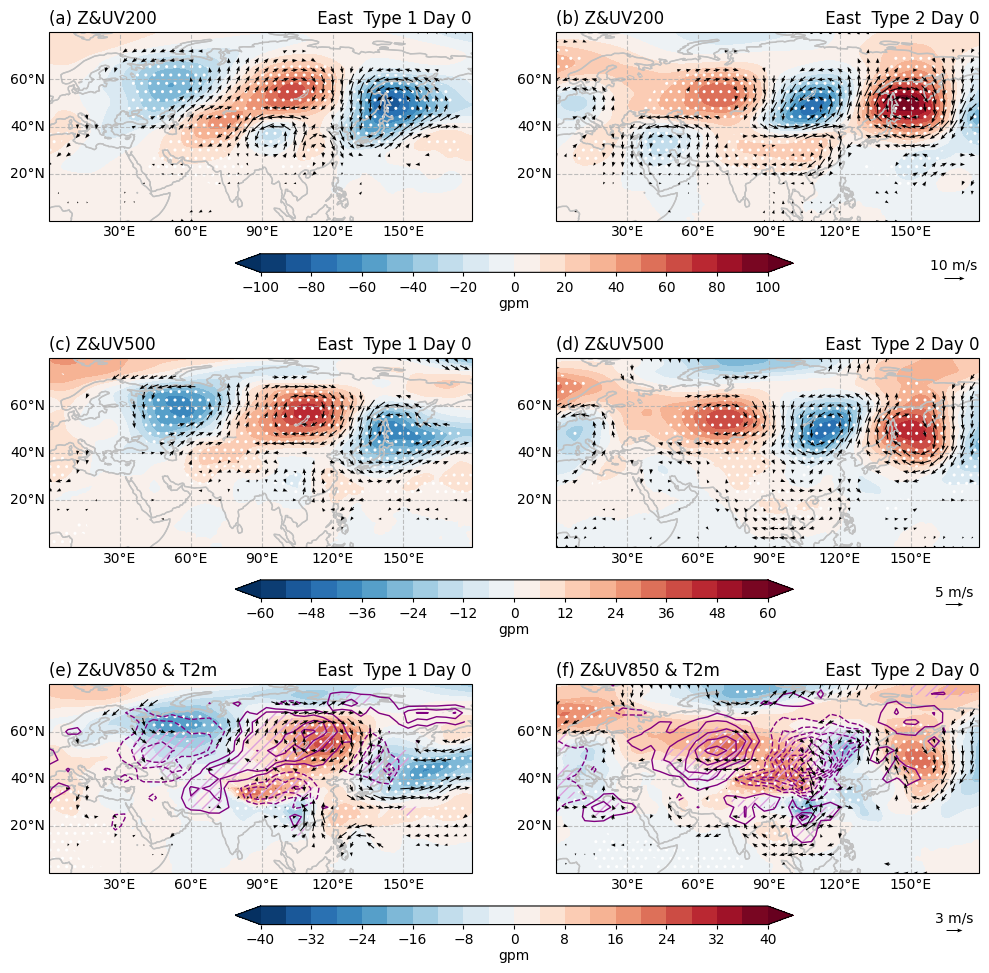

In [14]:
levs = [200, 500, 850]
levelmax = [100, 60, 40] #, 10
levelt = np.linspace(-4, 4, 21)
levelt = levelt[levelt!=0]
qkus = [10, 5, 3] #, 100
scales = [250, 150, 80]

fig, axs = eplt.subplots(nrows=len(levelmax), ncols=nc, figsize=[12, 12], 
                         proj='cyl')
eplt.formats(axs, lonlim=(lonw, 179), latlim=(lats, latn), latloc=20, 
             abc='(a)', lake=True)

for icol in range(nc):
    if switch_label:
        isin = np.where(fcluster == int(1 - icol))
    else:
        isin = np.where(fcluster == icol)
    # isin = np.where(fcluster==icol)
    for irow in range(len(levelmax)):
        
        z, p_z = zbase.getvar_ano_pl(levs[irow], isin=isin)
        u_temp, p_u = ubase.getvar_ano_pl(levs[irow], isin=isin)
        v_temp, p_v = vbase.getvar_ano_pl(levs[irow], isin=isin)
        u, v, u0, v0 = eplt.uv_sig(u_temp, v_temp, p_u, p_v, pvalue)

        ax1 = axs[irow, icol]
        level = np.linspace(-levelmax[irow], levelmax[irow], 21)
        pic = eplt.contourf(ax1, z, levels=level)
        eplt.plt_sig(ax1, p_z, x=lonz, y=latz, method=1, hatches='..', color='w')
        flux = eplt.vector(ax1, u, v, headwidth=3.8, zorder=99)

        if irow == 2:
            t, p_t = tbase.getvar_ano_sl(isin=isin)
            p_t = np.where([(t > 0.2)|(t<-0.2)], p_t, 1)[0]
            eplt.contour(ax1, t, level=levelt, color='purple', lw=1., fs='xx-small')
            eplt.plt_sig(ax1, p_t, tbase.lon, tbase.lat, color='plum', hatches='///')
            eplt.formats(ax1, ltitle=f'Z&UV{levs[irow]} & T2m', 
                         rtitle=f'{region1}  Type {icol+1} Day {day}')

            # tp_shp = shpreader.Reader(r'D:\research\data\TiBetan\TPBoundary_2500\TPBoundary_2500.shp').geometries()  # change9
            # ax1.add_geometries(tp_shp, crs=ccrs.PlateCarree(), facecolor='darkgrey', edgecolor='none', zorder=90)
        else:
            eplt.formats(ax1, ltitle=f'Z&UV{levs[irow]}', 
                         rtitle=f'{region1}  Type {icol+1} Day {day}')

#         region_shp = shpreader.Reader('boundary/' + region + '.shp').geometries()
#         ax1.ax.add_geometries(region_shp, crs=ccrs.PlateCarree(), fc='none', ec='limegreen', ls='-', lw=1.5, zorder=99)

        if icol==1:
            eplt.addcolorbar(axs[irow], pic, ticks=level[::2], aspect=30, pad=0.12, 
                             shrink=0.6,ticklength=3, label='gpm')
            eplt.addquiver(ax1, flux, x=0.94, y=-0.3, u=qkus[irow], unit='m/s', size='medium') 
